## Problem set: Week 7 (Resting fMRI)
In this problem set you will load the correlation data from one of the Midnight Scan Club subjects (which has already been extracted using the Glasser MMP parcellation) and perform several analyses to characterize the network.

As before, skeletal code is provided - please fill in any areas where you see ...


In [46]:
import os,pickle,sys
import numpy,pandas
import nilearn.datasets
import nilearn.plotting
import matplotlib.pyplot as plt
import scipy.stats
import networkx as nx
import sklearn.metrics
import bct
from collections import Counter

from brainnetworks.r2z import r_to_z,z_to_r
%matplotlib inline

datadir = nilearn.datasets.get_data_dirs()[0]
if not os.path.exists(datadir):
    os.mkdir(datadir)
    
atlasdir='/home/vagrant/brain-networks-course/data/HCP-MMP1'

labelfile=os.path.join(atlasdir,'MMP_yeo2011_networks.csv')
labeldata=pandas.read_csv(labelfile)


In [47]:
# first load the data

sub=1
corrtype='gsr'  # use data with global signal regression
scrubtype='full' # don't use scrubbing


subdir=os.path.join(datadir,'MSC/ds000224/derivatives/fmriprep/sub-MSC%02d/'%sub)

corrs=pickle.load(open(os.path.join(subdir,'sub-MSC%02d_task-rest_corrmtx.pkl'%sub),'rb'))



Now compute the mean correlation matrix across sesssions, using the r-to-z transform to first convert them to Z scores and then convert back to r values after averaging. The correlation data are stored in a dictionary, with the following key structure:

> ```corrs[session num][corrtype:{'gsr','nogsr'}][scrubtype:{'scrubbed','full'}]```

We will use corrtype and scrubtype as specified above

In [48]:
corrsum=numpy.zeros(corrs[1][corrtype][scrubtype].shape)
for s in corrs:
    sesscor=corrs[s][corrtype][scrubtype]
    corrsum+=r_to_z(sesscor)
    
meancorr=z_to_r(corrsum/len(corrs))
    



/home/vagrant/anaconda3/envs/py3/lib/python3.6/site-packages/brainnetworks/r2z.py:9: RuntimeWarning: divide by zero encountered in true_divide
  z=0.5*numpy.log((1.0+r)/(1.0-r))


**Problem 1**: Create a binary adjacency matrix with a density of 5%, and use this to create a NetworkX graph.  Be sure to do the following:

- exclude the diagonal when computing the cutoff 
- zero out the diagonal before creating the graph
- extract the giant component from the graph (calling the resulting variable ```Gc```)
- print the number of nodes in the giant component

In [49]:
# determine cutoff for 5% density of the correlation matrix
# using just the upper triangle of the matrix
thresh=95  # in percent
cutoff=scipy.stats.scoreatpercentile(meancorr[numpy.triu_indices_from(meancorr,1)],
                                    thresh)

#create symmetric binary adjacency matrix
# be sure to convert to integer
adjmtx=(meancorr>cutoff).astype('int')

# zero out the diagonal in the adjmtx
adjmtx[numpy.diag_indices_from(adjmtx)]=0

# Create numpy graph
G=nx.from_numpy_array(adjmtx)

# create graph for giant component
# first get all component subgraphs
comps=[i for i in nx.connected_component_subgraphs(G)]
# then take the largest
Gc= comps[0]

print('Giant component includes %d out of %d total nodes'%(len(Gc.nodes),len(G.nodes)))

# grab the label data for only the nodes in the giant component
labeldata_Gc=labeldata.loc[list(Gc.nodes)]
# add degree values to labeldata frame
labeldata_Gc['degree']=[Gc.degree[i] for i in labeldata_Gc.index]



Giant component includes 356 out of 360 total nodes


/home/vagrant/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


**Problem 3**: Perform community detection on the graph, using the Louvain algorithm for undirected binary graphs as implemented in the bct python package, and compute their overlap with the Yeo 7 network parcellation



In [50]:
# compute modularity using bct
Gc_adjmtx = adjmtx[Gc.nodes][:,Gc.nodes] #***adjmtx of the Gc
mod_binary=bct.modularity_louvain_und(Gc_adjmtx)
 
print('modularity:',mod_binary[1])
print('Multilevel modularity optimization identifed %d communities'%len(numpy.unique(mod_binary[0])))

# compute adjusted rand score using method from sklearn.metrics
ari=sklearn.metrics.adjusted_rand_score(mod_binary[0],labeldata_Gc['Yeo7'])
print('Adjusted Rand index compared to Yeo 7 networks: %0.3f'%ari)



modularity: 0.6561674608244701
Multilevel modularity optimization identifed 7 communities
Adjusted Rand index compared to Yeo 7 networks: 0.396


**Problem 4**: Estimate the normalized rich club coefficient for this network and plot the coefficients across the range of degree values.  Find the smallest degree value  for which the rich club coefficient is greater than 2, which we will use to define the rich club nodes.

In [51]:
# embed computation of rcc within a try/catch since it fails
# pretty regularly with a ZeroDivisionError
good_rcc=False
while not good_rcc:
    try:
        rcc = nx.rich_club_coefficient(Gc,normalized=True,Q=10)
        good_rcc=True
    except ZeroDivisionError:
        print('error, retrying')
        
# put into a data frame
rccdata=pandas.DataFrame([(i,rcc[i]) for i in rcc.keys()],
                         columns=['degree','rcc'])


# find the degree cutoff for rcc >= 2
rcc_thresh = 2
degree_cutoff = pandas.DataFrame.first_valid_index(
    rccdata.where(rccdata['rcc']>=rcc_thresh))
print('degree_cutoff:',degree_cutoff) 

rc_size=sum( labeldata_Gc['degree'] >= degree_cutoff )
print(rc_size,'nodes in rich club')

degree_cutoff: 35
43 nodes in rich club


**Problem 5:** For each of the Yeo7 networks, determine how many rich club members fall within that network.

In [52]:
# first create a data frame containing label data just for rcc members
criteria = labeldata_Gc['degree'] >= degree_cutoff
labeldata_rcc = labeldata_Gc[criteria]

# use collections.Counter to generate a list of the counts of members in each
# Yeo7 network
c=Counter(labeldata_rcc['YeoDesc7'])
print(c)

Counter({'Visual': 21, 'VentralAttention': 13, 'DorsalAttention': 6, 'Default': 2, 'Somatomotor': 1})


**Problem 6:** First, compute the node betweenness centrality and edge betweeness centrality for the giant component network.  

In [53]:
# compute edge betweenness centrality
ebc=nx.edge_betweenness_centrality(Gc)

# compute node betweenness centrality
bc=nx.betweenness_centrality(Gc)


Then, compute the mean betweenness centrality for edges separated by whether they include 0, 1, or 2 members of the rich club, and print out the mean values for each.

In [57]:
### okay so i want to make some sort of dataframe which separates into
#0 1 and 2 members of rich club, and then i can compute the mean 
#from that
#labeldata_rcc['Unnamed: 0']

rc_0 = []
rc_1 = []
rc_2 = []

rc_nodes = labeldata_rcc['Unnamed: 0'].tolist()

for key,val in ebc.items():
    if key[0] in rc_nodes:
        if key[1] in rc_nodes:
            rc_2.append(val)
        else: rc_1.append(val)
    else:
        if key[1] in rc_nodes:
            rc_1.append(val)
        else: rc_0.append(val)

print ("mean ebc for 0 rich club members: ", numpy.mean(rc_0) )
print ("mean ebc for 1 rich club members: ", numpy.mean(rc_1) )
print ("mean ebc for 2 rich club members: ", numpy.mean(rc_2) )


mean ebc for 0 rich club members:  0.001303639459318467
mean ebc for 1 rich club members:  0.0010032096606917421
mean ebc for 2 rich club members:  0.0004747857984713991


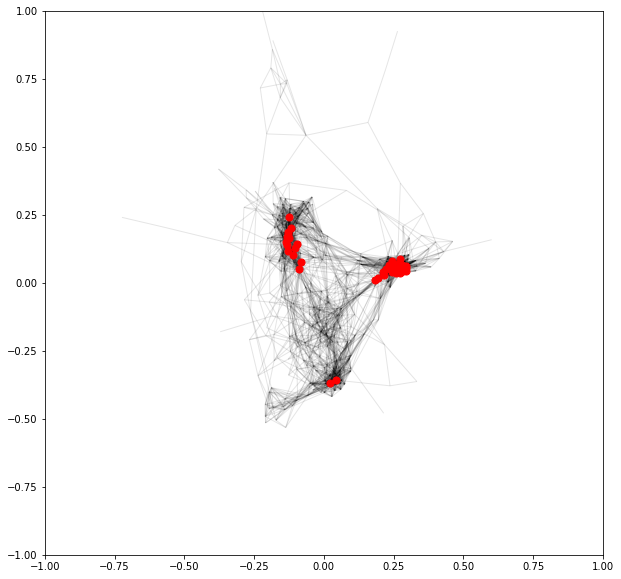

In [58]:
#plot Gc with rich clubs in red
plt.figure(figsize=(10,10))
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
layout=nx.spring_layout(Gc)
nx.draw_networkx_edges(Gc,pos=layout,alpha=0.1)
nx.draw_networkx_nodes(Gc, pos=layout, nodelist=rc_nodes, node_size=50)

There are  1898  edges with 0 rcs in Gc out of  48828.0  possible. or  0.03887113951011715

There are  898  edges with 1 rcs in Gc out of  13459.0  possible. or  0.06672115313173341

There are  435  edges with 2 rcs in Gc out of  903.0  possible. or  0.48172757475083056

Incorporating 0 values for rc0, adjusted ebc is  5.06739512940618e-05
Incorporating 0 values for rc1, adjusted ebc is  6.69353053942481e-05
Incorporating 0 values for rc2, adjusted ebc is  0.00022871741122376364


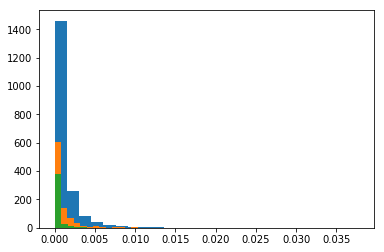

In [59]:
#plotting the histograms of the ebcs of edges
#blue is 2 rc, orange 1 rc, green 2 rc

f1 = plt.hist(rc_0,25)
f2 = plt.hist(rc_1,25)
f3 = plt.hist(rc_2,25)

rc_node_num = len(rc_nodes)
non_rc_node_num = len(Gc.nodes) - len(rc_nodes)
#calculating total potential
possible_edges = (len(Gc.nodes)*(len(Gc.nodes)-1))/2
possible_rc2_edges = ((rc_node_num)*(rc_node_num - 1))/2
possible_rc0_edges = ((non_rc_node_num)*(non_rc_node_num - 1))/2
possible_rc1_edges = possible_edges - possible_rc0_edges - possible_rc2_edges

#print out the ratio of edges in Gc vs possible edges
print("There are ", len(rc_0), " edges with 0 rcs in Gc out of ", 
      possible_rc0_edges ," possible. or ", len(rc_0)/possible_rc0_edges)
print("\nThere are ", len(rc_1), " edges with 1 rcs in Gc out of ", 
      possible_rc1_edges ," possible. or ", len(rc_1)/possible_rc1_edges)
print("\nThere are ", len(rc_2), " edges with 2 rcs in Gc out of ", 
      possible_rc2_edges ," possible. or ", len(rc_2)/possible_rc2_edges)


#print out the "adjusted" ebc factoring in null values
print("\nIncorporating 0 values for rc0, adjusted ebc is ", sum(rc_0)/possible_rc0_edges)
print("Incorporating 0 values for rc1, adjusted ebc is ", sum(rc_1)/possible_rc1_edges)
print("Incorporating 0 values for rc2, adjusted ebc is ", sum(rc_2)/possible_rc2_edges)


Now compute the mean betweenness centrality for nodes, separated by whether the nodes are members of the rich club or not, and print the values for each.

In [60]:
rc_node_bc = []
non_rc_node_bc = []

for key,val in bc.items():
    if key in rc_nodes:
        rc_node_bc.append(val)
    else: non_rc_node_bc.append(val)

print ("mean bc for rich club members: ", numpy.mean(rc_node_bc) ) 
print ("mean bc for non rich club members: ", numpy.mean(non_rc_node_bc))


mean bc for rich club members:  0.012539901048146873
mean bc for non rich club members:  0.006572179058063817


How does centrality of both nodes and edges relate to rich club membership?  Please explain (insert your answer in the following cell).

Rich club members have a greater node betweenness centrality than non-rich club members. This means that rich club nodes on average have a greater amount of shortest path lengths passing through them.This makes sense because rich club members are defined as being high degree nodes. Even though they preferentially link between one another, their high degree means that they are more likely to be a part of a shortest path. However, for edge betweenness centrality, edges with a greater amount of rich club members have on average a lower edge betweenness centrality. This is a confusing solution, since it seems as though since rich club members have greater degrees and greater node centrality, they would have more shortest paths passing through them, even if they are preferentially connected with other rich club members. One possible explanation for this is that, by looking only at edges in the graph instead of all possible sets of nodes, we do not get any of the "0" values that would result from no shortest paths traversing through two nodes, which would happen if two nodes were not connected. As shown above, almost half of all possible connections exist in the rich club, while for edges with 1 or 0 rich club nodes, a very small proportion are present in the graph (~ 3% and 6 %). For example, since there are roughly 30x as many possible 0 rich club edges as 2 rich club edges, if the mean betweenness centrality were equal, you would expect the histogram to show values roughly 30x greater for 0 rich club members vs 2 rich club members. If we were to incorporate the null values of potential edges, we would drastically decrease the mean edge betweeness for sets with 0 or 1 rich club members. This would mean that mean edge betweenness would increase with more rich club members, which is what we would expect for connections between higher degree nodes, even if these higher degree nodes are preferentially connected with one another. This is what we see, with an adjusted ebc for 2 rich club member edges being about 4.5x higher than the adjusted ebc for 1 rich club member edges.